In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import datetime as dt
import calendar
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

The attached CSV file contains a price quote time series for a security listed on a foreign exchange. It is quoted
twice daily for each currency it's quoted in. The quotes come in at inconsistent times, and sometimes not at all. The security
is quite volatile, and there is a differential in liquidity for each of the currencies it's quoted in. 

Your job is to read, clean, and comprehend the data, and then develop a methdology (either algorithmic or machine learning)
for determining which currency any future quote belongs to (assume you do not know this instantly, but only after the NEXT 
quote comes in). This should be done as a def that you can pass a quote to, and it returns it's best 'guess' for which
currency it's quoted in, and the probability of that guess.

# Steps

For our purpouse, F1 Score is used as indicator of the quality of the classification, as it's a function of Precision and Recall and represents a good balance between those two metrics.
### 1. Data import
### 2. Descriptive statistics and graphs
### 3. Simple algorithmic approach
The first version compares the quote that comes in at time t with the currencies at t-2. The quote is labelled with the currency of the closest quote. This because we don't know the true label of the quote at t-1 prior to the release of the quote a t. f1 score = 69% <br>
The second approach uses the same "closest value" logic but this time it considers the Exponential Weigthing Moving Average with different lookback windows (LB) instead of the row prices as reference value. We can see that the highest performance is achieved for LB = 10. F1 score = 78%
### 4. Multi-layer Perceptron classifier
Here, a MLP classifier uses the quotes as single features for the prediction. F1 score = 60%
### 5. Supervised categorical Naive Bayes  
Although this approach deviates for the main tasks, this section is added to the notebook to show the strong predictive capabilities of this methodology which considers only hour and day of the week as independent variables. F1 score = 94%

# 1. Data import

In [2]:
df = pd.read_csv(r"price_data_multicurrency_train.csv")
df.columns = ['Time', 'Price', 'Cur']
df['DateTime'] = [dt.datetime.strptime(i, "%Y-%m-%d %H:%M:%S.%f") for i in df['Time']]
df['Weekday'] = [i.weekday() for i in df['DateTime']]
df['Day'] = [calendar.day_name[i.weekday()] for i in df['DateTime']]
df['Hour'] = df.DateTime.dt.hour
df['Date'] = [i.date() for i in df['DateTime']]
df['Time'] = [i.time() for i in df['DateTime']]
df['Ret'] = df.groupby('Cur')['Price'].apply(lambda x: (x/x.shift(1) - 1))
df['EWMA'] = df.groupby('Cur')['Price'].apply(lambda x : x.ewm(span=10, adjust=False).mean())
#df['DateTime_dt'] = pd.to_datetime(df['DateTime'])
#df = df.set_index('DateTime')
print(df.shape)
df.head()

(489, 10)


,Time,Price,Cur,DateTime,Weekday,Day,Hour,Date,Ret,EWMA
0,22:28:01.747000,0.0936,EUR,2018-01-02 22:28:01.747,1,Tuesday,22,2018-01-02,NaN,0.093600
1,02:17:53.896000,0.0880,EUR,2018-01-03 02:17:53.896,2,Wednesday,2,2018-01-03,-0.059829,0.092582
2,09:57:12.584000,0.0747,AUD,2018-01-03 09:57:12.584,2,Wednesday,9,2018-01-03,NaN,0.074700
3,22:09:31.159000,0.0700,EUR,2018-01-03 22:09:31.159,2,Wednesday,22,2018-01-03,-0.204545,0.088476
4,02:22:08.771000,0.0652,EUR,2018-01-04 02:22:08.771,3,Thursday,2,2018-01-04,-0.068571,0.084244


# 2. Descriptive statistics and graphs

In [3]:
df['Cur'].value_counts()

EUR    261
AUD    173
USD     55
Name: Cur, dtype: int64

### Day of the week

Text(0.5, 0, '')

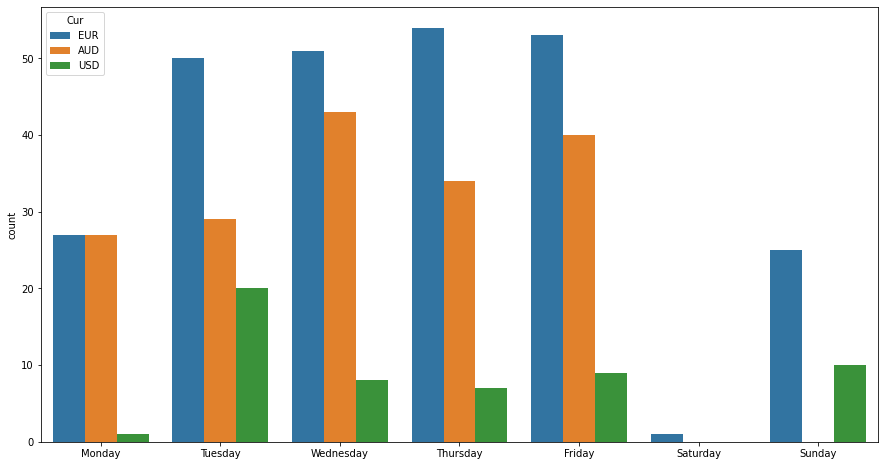

In [4]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.countplot(x="Day", hue="Cur", data=df, order = day_order)
plt.xlabel("")

### Line chart

**Quotes**

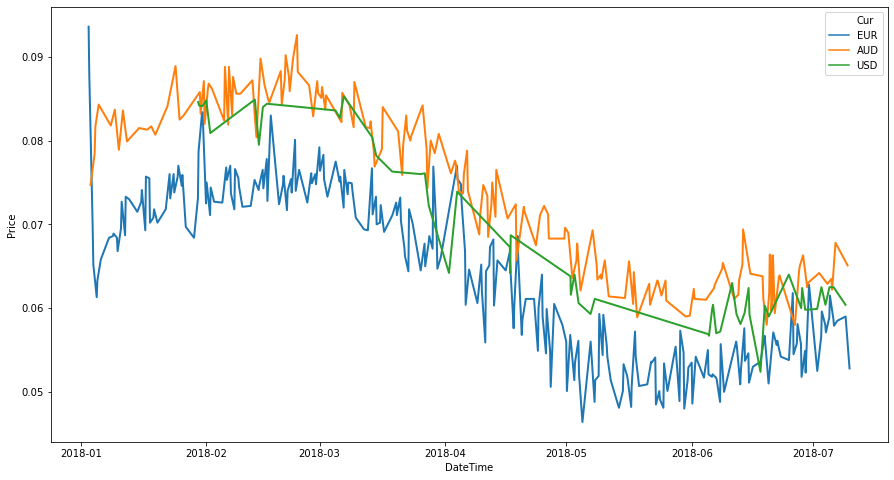

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.lineplot(data=df, x="DateTime", y="Price", hue="Cur", linewidth=2)

**Exponentially Weighted Moving Averages (EWMA) - 5 periods**

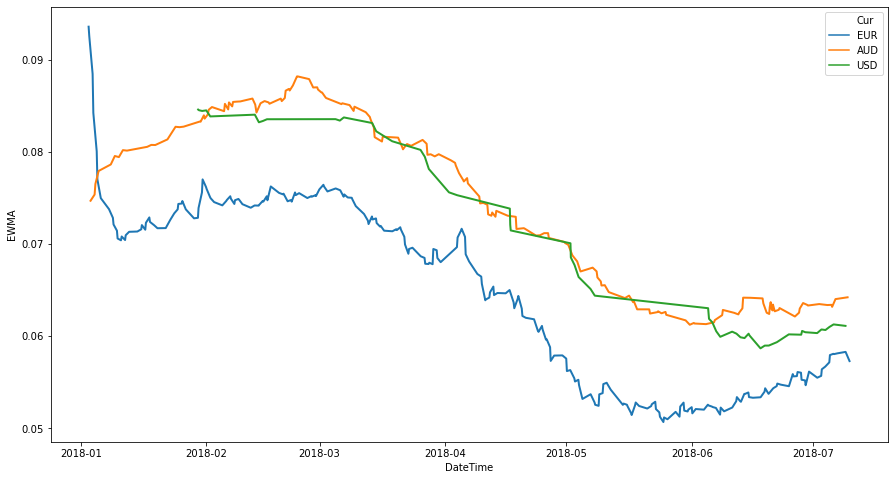

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.lineplot(data=df, x="DateTime", y="EWMA", hue="Cur", linewidth=2)

### Time of the day

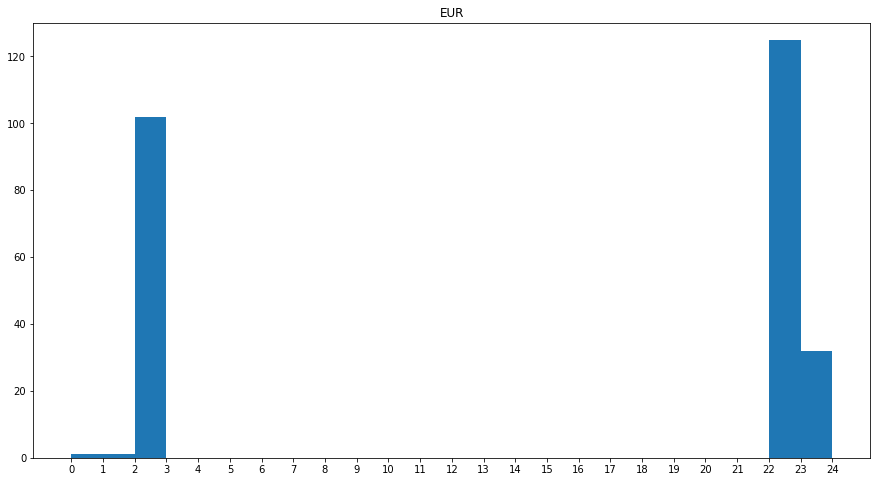

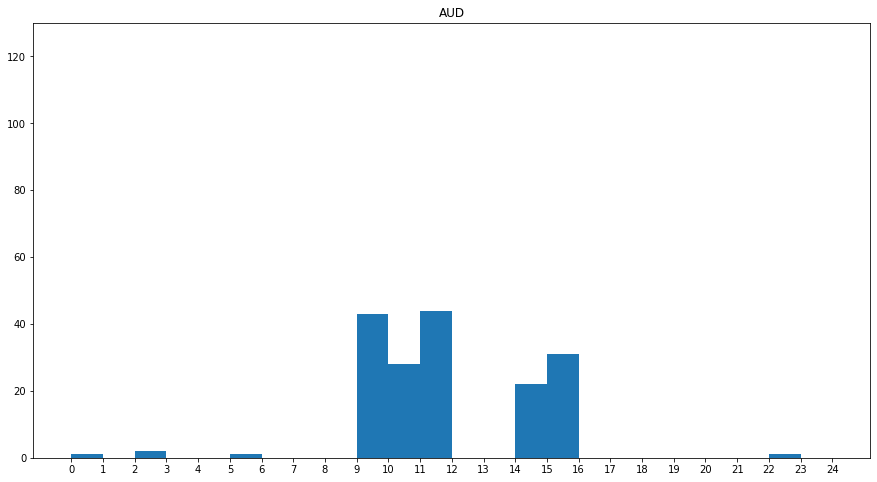

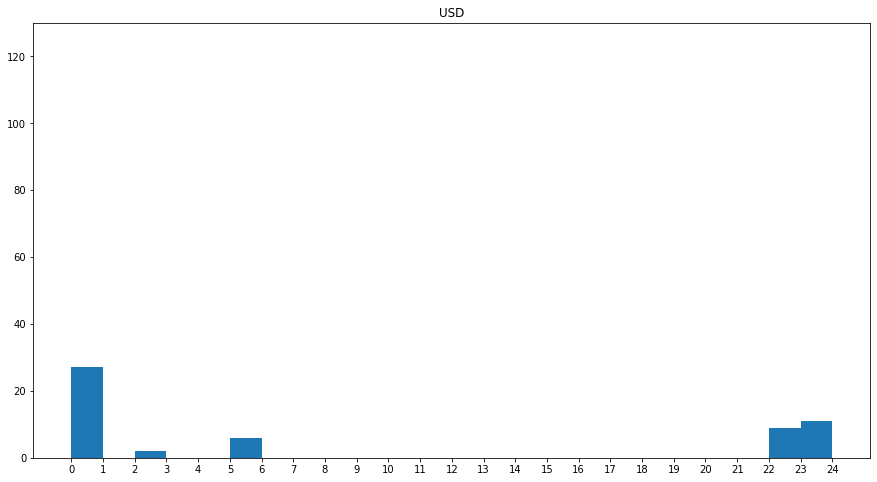

In [7]:
df_time = df.copy()
df_time['hours'] = df.DateTime.dt.hour
curs = ['EUR', 'AUD', 'USD']
for i in curs:    
    cur = df_time[df_time['Cur'] == i]

    bins_list = list(range(0, 25)) 
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax.hist(cur.hours, bins = bins_list)
    plt.xticks(bins_list)
    plt.title(i)
    plt.ylim([0, 130])
    plt.show()    

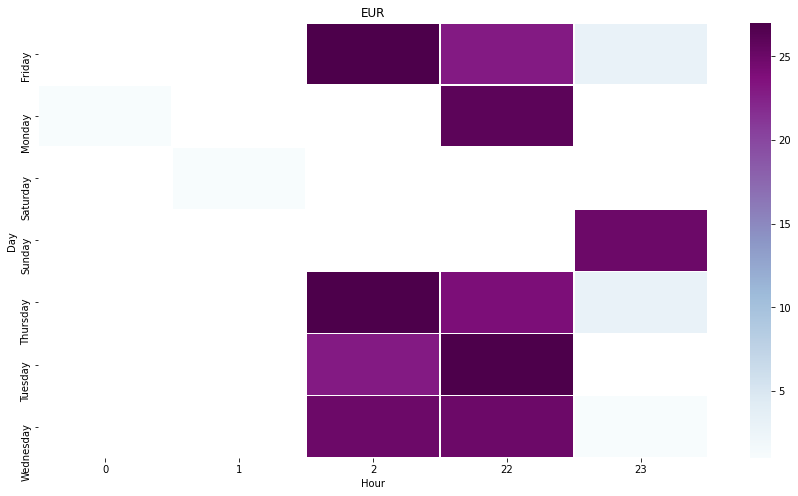

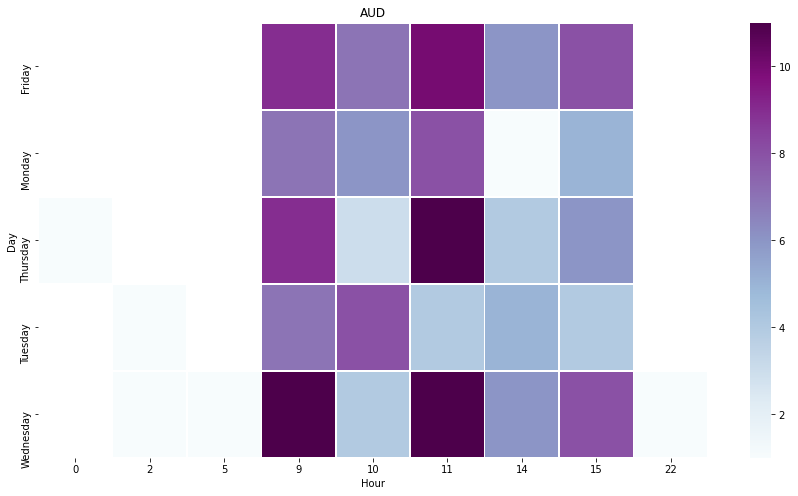

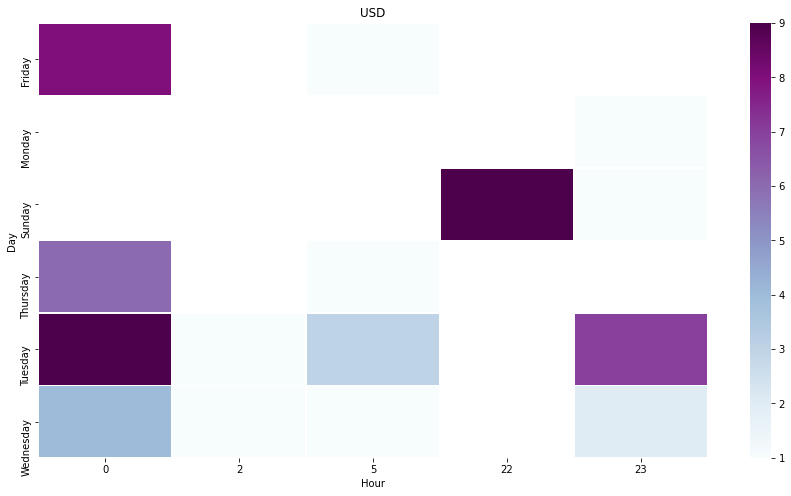

In [8]:
df_time = df.copy()
df_time['hours'] = df.DateTime.dt.hour
curs = ['EUR', 'AUD', 'USD']
for i in curs:   
    cur = df_time[df_time['Cur'] == i]
    df_time_g = cur.groupby(['Hour', 'Day']).size().reset_index()
    df_time_g['Hour'] = df_time_g['Hour'].astype("Int64")
    df_time_g.columns = ['Hour', 'Day', 'Count']
    df_time_g = df_time_g.pivot('Day', 'Hour', 'Count')
    df_time_g.head()
    
        
    f, ax = plt.subplots(figsize=(15,8))
    plt.title(i)
    sns.heatmap(df_time_g, fmt="d", linewidths=.5, ax=ax, cmap="BuPu")

### Returns

In [9]:
ret = df.copy()
ret.head()

,Time,Price,Cur,DateTime,Weekday,Day,Hour,Date,Ret,EWMA
0,22:28:01.747000,0.0936,EUR,2018-01-02 22:28:01.747,1,Tuesday,22,2018-01-02,NaN,0.093600
1,02:17:53.896000,0.0880,EUR,2018-01-03 02:17:53.896,2,Wednesday,2,2018-01-03,-0.059829,0.092582
2,09:57:12.584000,0.0747,AUD,2018-01-03 09:57:12.584,2,Wednesday,9,2018-01-03,NaN,0.074700
3,22:09:31.159000,0.0700,EUR,2018-01-03 22:09:31.159,2,Wednesday,22,2018-01-03,-0.204545,0.088476
4,02:22:08.771000,0.0652,EUR,2018-01-04 02:22:08.771,3,Thursday,2,2018-01-04,-0.068571,0.084244


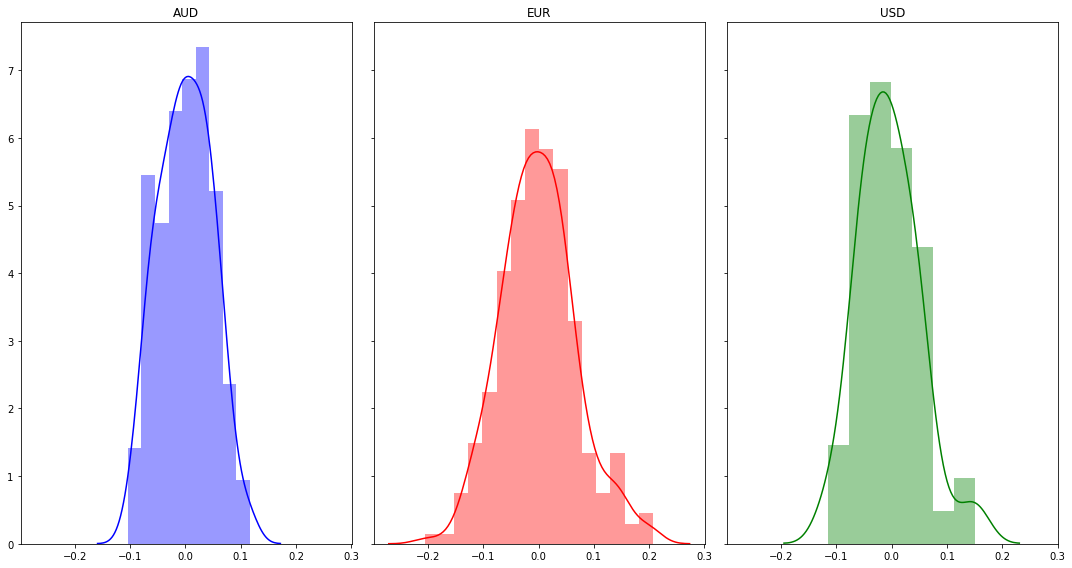

In [10]:
f, axes = plt.subplots(1, 3, figsize=(15, 8), sharex=True, sharey=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(ret.loc[ret['Cur'] == 'AUD', 'Ret'].values, kde=True, color="b", ax=axes[0]).set(title='AUD')

# Plot a kernel density estimate and rug plot
sns.distplot(ret.loc[ret['Cur'] == 'EUR', 'Ret'].values, color="r", ax=axes[1]).set(title='EUR')

# Plot a filled kernel density estimate
sns.distplot(ret.loc[ret['Cur'] == 'USD', 'Ret'].values, color="g",  ax=axes[2]).set(title='USD')

#plt.setp(axes)
plt.tight_layout()
plt.show()

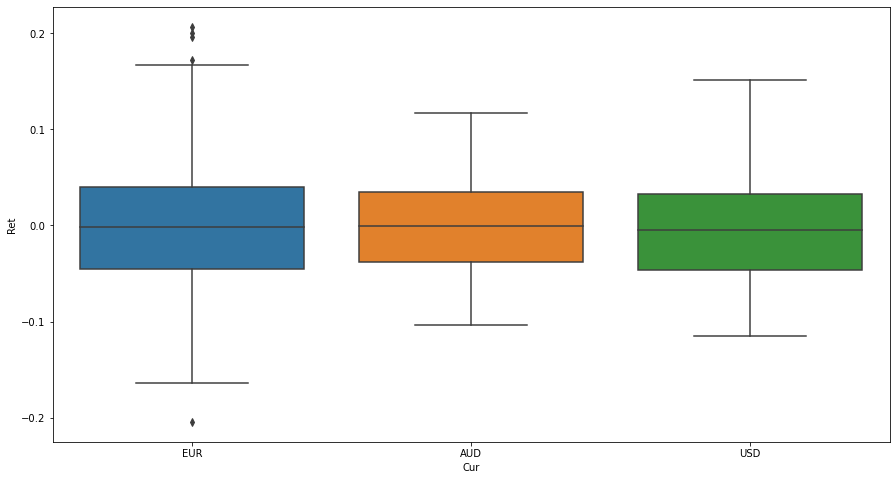

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
sns.boxplot(x="Cur", y="Ret", data=ret)

# 3. Simple algorithmic approach

**Rationale: The quote is assigned to the currency with the closest last value at t-2**

### Logic

In [12]:
#ensure dataframe is sorted and take the last quote for each group
df_a = df.sort_values(by=['DateTime'])
df_a_last = df_a.groupby('Cur').tail(1)
df_a_last

,Time,Price,Cur,DateTime,Weekday,Day,Hour,Date,Ret,EWMA
485,22:45:52.916000,0.0604,USD,2018-07-08 22:45:52.916,6,Sunday,22,2018-07-08,-0.033600,0.061113
487,11:11:27.310000,0.0651,AUD,2018-07-09 11:11:27.310,0,Monday,11,2018-07-09,-0.039823,0.064217
488,22:43:21.603000,0.0528,EUR,2018-07-09 22:43:21.603,0,Monday,22,2018-07-09,-0.105085,0.057290


In [13]:
quote = 0.060
df_a_last2 = df_a_last.copy()
df_a_last2.loc[:,'Dist'] = ((df_a_last2['Price'] - quote)**2).values
df_a_last2

,Time,Price,Cur,DateTime,Weekday,Day,Hour,Date,Ret,EWMA,Dist
485,22:45:52.916000,0.0604,USD,2018-07-08 22:45:52.916,6,Sunday,22,2018-07-08,-0.033600,0.061113,1.600000e-07
487,11:11:27.310000,0.0651,AUD,2018-07-09 11:11:27.310,0,Monday,11,2018-07-09,-0.039823,0.064217,2.601000e-05
488,22:43:21.603000,0.0528,EUR,2018-07-09 22:43:21.603,0,Monday,22,2018-07-09,-0.105085,0.057290,5.184000e-05


In [14]:
#select value column with minimum distance
df_a_last2.loc[df_a_last2['Dist'].idxmin()]['Cur']

'USD'

### Example 

In this example the function is executed dynamically for the last 289 observations. The new quote is compared with the last price for each currency and the quote is assigned to the currency with the smallest disnstance.  

In [15]:
def minimum_distance_classifier(df, quote):
    df_a = df.sort_values(by=['DateTime'])
    df_a_last = df_a.groupby('Cur').tail(1)
    df_a_last2 = df_a_last.copy()
    df_a_last2.loc[:,'Dist'] = ((df_a_last2['Price'] - quote)**2).values
    cur = df_a_last2.loc[df_a_last2['Dist'].idxmin()]['Cur']
    return cur

**Using last quotes**

In [16]:
preds = []
for i, row in df.iloc[200:, :].iterrows():
    df_slice = df.iloc[:i-1,:].tail()
    pred = minimum_distance_classifier(df_slice, row['Price'])
    preds.append([row['Cur'], pred])

df_aa = pd.DataFrame(preds, columns = ['True', 'Pred'])
df_aa

,True,Pred
0,AUD,AUD
1,EUR,EUR
2,EUR,EUR
3,AUD,AUD
4,AUD,AUD
...,...,...
284,EUR,EUR
285,USD,USD
286,EUR,EUR
287,AUD,AUD


In [17]:
print(confusion_matrix(df_aa['True'].values, df_aa['Pred'].values))
print(f1_score(df_aa['True'].values, df_aa['Pred'].values, average='micro'))

[[ 62   9  30]
 [ 14 120  14]
 [ 14   8  18]]
0.6920415224913494


**Using EWMA**

In [18]:
preds = []
scores = []
df_ewma = df.copy()
for k in range(1, 20):
    df_ewma['EWMA'] = df_ewma.groupby('Cur')['Price'].apply(lambda x : x.ewm(span=k, adjust=False).mean())
    for i, row in df_ewma.iloc[200:, :].iterrows():
        df_slice = df_ewma.iloc[:i-1,:].tail()
        pred = minimum_distance_classifier(df_slice, row['EWMA'])
        preds.append([row['Cur'], pred])

        df_aa2 = pd.DataFrame(preds, columns = ['True', 'Pred'])
        score = f1_score(df_aa2['True'].values, df_aa2['Pred'].values, average='micro')
    scores.append([k, score])

**The chart belows display the sensitivity of our accuracy indicator to changes in the EWMA lookback period**

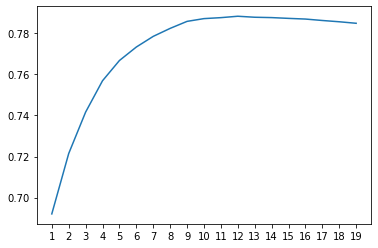

In [19]:
from matplotlib.ticker import MaxNLocator
df_ewma2 = pd.DataFrame(scores, columns = ['EWMA lookback windown', 'scores'])
plt.plot(df_ewma2['EWMA lookback windown'], df_ewma2['scores'])
plt.xticks(df_ewma2['EWMA lookback windown'])
plt.show()

# 4. Multi-layer Perceptron classifier

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [20]:
df_nn = df.dropna()
train, test = train_test_split(df_nn, test_size=.2, random_state=40)

features = ['Price']
X_train = train[features].values
y_train = train['Cur'].values
X_test = test[features].values
y_test = test['Cur'].values
y_test_date = test['Date'].values
y_test_time = test['Time'].values

print("Size of the train set: " + str(train.shape))
print("Size of the test set: " + str(test.shape))

Size of the train set: (388, 10)
Size of the test set: (98, 10)


### Grid Search

In [21]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=100)

parameter_space = {
    'hidden_layer_sizes': [(5, 2), (10, 4), (20,5)],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05],
}

In [22]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05],
                         'hidden_layer_sizes': [(5, 2), (10, 4), (20, 5)],
                         'solver': ['sgd', 'adam', 'lbfgs']})

In [23]:
# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'alpha': 1e-05, 'hidden_layer_sizes': (20, 5), 'solver': 'lbfgs'}
0.546 (+/-0.006) for {'alpha': 1e-05, 'hidden_layer_sizes': (5, 2), 'solver': 'sgd'}
0.477 (+/-0.192) for {'alpha': 1e-05, 'hidden_layer_sizes': (5, 2), 'solver': 'adam'}
0.585 (+/-0.095) for {'alpha': 1e-05, 'hidden_layer_sizes': (5, 2), 'solver': 'lbfgs'}
0.546 (+/-0.006) for {'alpha': 1e-05, 'hidden_layer_sizes': (10, 4), 'solver': 'sgd'}
0.546 (+/-0.006) for {'alpha': 1e-05, 'hidden_layer_sizes': (10, 4), 'solver': 'adam'}
0.598 (+/-0.119) for {'alpha': 1e-05, 'hidden_layer_sizes': (10, 4), 'solver': 'lbfgs'}
0.477 (+/-0.192) for {'alpha': 1e-05, 'hidden_layer_sizes': (20, 5), 'solver': 'sgd'}
0.546 (+/-0.006) for {'alpha': 1e-05, 'hidden_layer_sizes': (20, 5), 'solver': 'adam'}
0.676 (+/-0.167) for {'alpha': 1e-05, 'hidden_layer_sizes': (20, 5), 'solver': 'lbfgs'}
0.546 (+/-0.006) for {'alpha': 0.0001, 'hidden_layer_sizes': (5, 2), 'solver': 'sgd'}
0.407 (+/-0.191) for {'alpha': 0.0001, 'hid

In [24]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=100, solver='lbfgs', alpha=1e-05,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)

C:\Users\Utente\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=100,
              random_state=1, solver='lbfgs')

In [25]:
y_pred_nn = clf.predict(X_test)

In [26]:
clf.predict_proba(X_test)[:5]

array([[0.22717406, 0.6491723 , 0.12365364],
       [0.30883575, 0.58601525, 0.105149  ],
       [0.10931434, 0.73264494, 0.15804072],
       [0.11202506, 0.73092238, 0.15705256],
       [0.24323001, 0.63697495, 0.11979504]])

In [27]:
from sklearn.metrics import classification_report
print(f1_score(y_test, y_pred_nn, average='micro'))
print("\nConfusion Matrix \n")
print(confusion_matrix(y_test, y_pred_nn))
print('Results on the test set:')
print(classification_report(y_test, y_pred_nn))

0.5918367346938775

Confusion Matrix 

[[15 25  0]
 [ 5 43  0]
 [ 2  8  0]]
Results on the test set:
              precision    recall  f1-score   support

         AUD       0.68      0.38      0.48        40
         EUR       0.57      0.90      0.69        48
         USD       0.00      0.00      0.00        10

    accuracy                           0.59        98
   macro avg       0.42      0.42      0.39        98
weighted avg       0.56      0.59      0.54        98



C:\Users\Utente\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Supervised categorical Naive Bayes  

In [28]:
df.head()

,Time,Price,Cur,DateTime,Weekday,Day,Hour,Date,Ret,EWMA
0,22:28:01.747000,0.0936,EUR,2018-01-02 22:28:01.747,1,Tuesday,22,2018-01-02,NaN,0.093600
1,02:17:53.896000,0.0880,EUR,2018-01-03 02:17:53.896,2,Wednesday,2,2018-01-03,-0.059829,0.092582
2,09:57:12.584000,0.0747,AUD,2018-01-03 09:57:12.584,2,Wednesday,9,2018-01-03,NaN,0.074700
3,22:09:31.159000,0.0700,EUR,2018-01-03 22:09:31.159,2,Wednesday,22,2018-01-03,-0.204545,0.088476
4,02:22:08.771000,0.0652,EUR,2018-01-04 02:22:08.771,3,Thursday,2,2018-01-04,-0.068571,0.084244


### Prepare the training set - features = [Hour, Weekday]

In [29]:
train, test = train_test_split(df, test_size=.2, random_state=41)

features = ['Hour', 'Weekday']
X_train = train[features].values
y_train = train['Cur'].values
X_test = test[features].values
y_test = test['Cur'].values
y_test_date = test['Date'].values
y_test_time = test['Time'].values

print("Size of the train set: " + str(train.shape))
print("Size of the test set: " + str(test.shape))

Size of the train set: (391, 10)
Size of the test set: (98, 10)


### Probabilities

In [30]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
clf.fit(X_train, y_train)

list_probas = []
for d, t, i, true in zip(y_test_date, y_test_time, X_test, y_test):
    y_i = i.reshape(1, -1)
    y_p = clf.predict(y_i) #single quote
    prob_aud, prob_eur, prob_usd = clf.predict_proba(y_i)[0]
    list_probas.append([d, t, true, y_p, prob_aud, prob_eur, prob_usd])
    
df_probas = pd.DataFrame(list_probas, columns = ['Date', 'Time', 'True', 'Predicted', 'Pr_AUD', 'Pr_EUR', 'Pr_USD'])
df_probas

,Date,Time,True,Predicted,Pr_AUD,Pr_EUR,Pr_USD
0,2018-05-21,10:57:58.181000,AUD,[AUD],0.948360,0.040828,0.010811
1,2018-02-28,22:46:56.629000,EUR,[EUR],0.024420,0.931973,0.043608
2,2018-03-04,22:40:55.753000,USD,[EUR],0.001289,0.932457,0.066253
3,2018-04-06,10:56:54.139000,AUD,[AUD],0.942452,0.037903,0.019646
4,2018-01-03,22:09:31.159000,EUR,[EUR],0.024420,0.931973,0.043608
...,...,...,...,...,...,...,...
93,2018-02-02,00:00:46.660000,USD,[USD],0.122583,0.113389,0.764027
94,2018-04-05,22:34:43.519000,EUR,[EUR],0.018350,0.947973,0.033678
95,2018-01-16,02:13:21.674000,EUR,[EUR],0.018586,0.952176,0.029238
96,2018-01-22,09:56:10.592000,AUD,[AUD],0.966381,0.026581,0.007038


### Confusion Matrix

In [31]:
y_pred = clf.predict(X_test)
print("F1 score")
print(f1_score(y_test, y_pred, average='micro'))
print("\nConfusion Matrix \n")
print(confusion_matrix(y_test, y_pred))
print('Results on the test set:')
print(classification_report(y_test, y_pred))

F1 score
0.9387755102040817

Confusion Matrix 

[[37  1  0]
 [ 0 50  0]
 [ 0  5  5]]
Results on the test set:
              precision    recall  f1-score   support

         AUD       1.00      0.97      0.99        38
         EUR       0.89      1.00      0.94        50
         USD       1.00      0.50      0.67        10

    accuracy                           0.94        98
   macro avg       0.96      0.82      0.87        98
weighted avg       0.95      0.94      0.93        98



In [32]:
def Currency_classifier(cls_train, quote):
    quote2 = quote.reshape(1, -1)
    y_p = cls_train.predict(quote2) 
    prob_aud, prob_eur, prob_usd = clf.predict_proba(quote2)[0]
    
    print("Hour: " + str(quote[0][0]) + ", Day: " + str(quote[0][1]))
    print("-"*30)
    print('Prob. to be AUD: ' + str(round(prob_aud, 3)))
    print('Prob. to be EUR: ' + str(round(prob_eur, 3)))
    print('Prob. to be USD: ' + str(round(prob_usd, 3)))
    print("-"*30)
    print("Prediction: " + str(y_p))

In [33]:
Currency_classifier(clf, y_i)

Hour: 22, Day: 2
------------------------------
Prob. to be AUD: 0.024
Prob. to be EUR: 0.932
Prob. to be USD: 0.044
------------------------------
Prediction: ['EUR']
